In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy
from scipy.optimize import curve_fit

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N+1])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

In [3]:
# choose which dataset to download
# ENGLAND
male_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=maleCases&format=json"
female_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=femaleCases&format=json"
hosp_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=cumAdmissionsByAge&format=json"
geographical_context = "England"

In [4]:
# LONDON
male_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&areaCode=E12000007&metric=maleCases&format=json"
female_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&areaCode=E12000007&metric=femaleCases&format=json"
hosp_url = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&areaCode=E40000003&metric=cumAdmissionsByAge&format=json"
geographical_context = "London"

In [5]:
# download api data
# +ve tests
response = get(male_url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()
age_tests_df_male = pd.DataFrame(response['body'])
age_tests_df_male.dropna(inplace=True)
age_tests_df_male['dateTime'] = pd.to_datetime(age_tests_df_male['date'])
age_tests_df_male.sort_values(by=['dateTime'], inplace=True)

response = get(female_url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()
age_tests_df_female = pd.DataFrame(response['body'])
age_tests_df_female.dropna(inplace=True)
age_tests_df_female['dateTime'] = pd.to_datetime(age_tests_df_female['date'])
age_tests_df_female.sort_values(by=['dateTime'], inplace=True)

# admissions
response = get(hosp_url, timeout=30)
print(response)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }\nStatus Code: {response.status_code}')
response = response.json()
age_admiss_df = pd.DataFrame(response['body'])
age_admiss_df.dropna(inplace=True)
age_admiss_df['dateTime'] = pd.to_datetime(age_admiss_df['date'])
age_admiss_df.sort_values(by=['dateTime'], inplace=True)

top_tests_date_male = sorted(list(set(age_tests_df_male.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
top_tests_date_female = sorted(list(set(age_tests_df_female.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
top_admiss_date = sorted(list(set(age_admiss_df.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
top_date = min(top_tests_date_male, top_tests_date_female, top_admiss_date)
print(top_date)

<Response [200]>
<Response [200]>
<Response [200]>
2022-01-05


In [6]:
# input defs
in_event = "+ve test"
out_event = "admitted"

train_start_date = "2020-11-15" 
train_end_date = "2021-03-15"
test_start_date = "2020-12-15"

train_start_date = "2021-06-01"
train_end_date = "2021-11-20"
test_start_date = "2021-09-01"
test_end_date = top_date

train_start_date = datetime.datetime.strptime(train_start_date, "%Y-%m-%d")
train_end_date = datetime.datetime.strptime(train_end_date, "%Y-%m-%d")
test_start_date = datetime.datetime.strptime(test_start_date, "%Y-%m-%d")

In [7]:
band_map_tests = {
    0:['15_to_19','20_to_24','25_to_29','30_to_34','35_to_39','40_to_44','45_to_49','50_to_54','55_to_59','60_to_64'],
    1:['65_to_69','70_to_74','75_to_79','80_to_84'], 
    2:['85_to_89','90+'],
}
band_map_admiss = {
    0:['18_to_64'],
    1:['65_to_84'], 
    2:['85+'],    
}
band_label = {
    0:'18 to 64',
    1:'65 to 84', 
    2:'85+',    
}

def list_of_dicts_to_age_bands(list_of_dicts, key, band_map):
    ret = np.array([0,0,0])
    for d in list_of_dicts:
        for band,band_labels in band_map.items():
            if d['age'] in band_labels:
                ret[band] += d[key]
    return ret

In [8]:
# set data (according to which api cell was used above)
def construct_stream(df, df_key, start_date, end_date, dict_key, band_map, diff=False):
    if diff:
        start_date = start_date - datetime.timedelta(days=1) 
    _df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
    dates = sorted(list(set(_df.dateTime.to_list())))
    stream = []
    list_of_list_of_dicts = _df[df_key].to_list()
    for list_of_dicts in list_of_list_of_dicts:
        v = list_of_dicts_to_age_bands(list_of_dicts, dict_key, band_map)
        stream.append(v)
    stream = np.array(stream, dtype=float)
    stream = np.transpose(stream)
    if diff:
        stream = np.diff(stream)
        dates = dates[1:]
    return dates, stream

dates_train, train_in_stream_male = construct_stream(age_tests_df_male, "maleCases", train_start_date, train_end_date, "value", band_map_tests, diff=True)
dates, train_in_stream_female = construct_stream(age_tests_df_female, "femaleCases", train_start_date, train_end_date, "value", band_map_tests, diff=True)
train_in_stream = train_in_stream_male + train_in_stream_female

dates_test, test_in_stream_male = construct_stream(age_tests_df_male, "maleCases", test_start_date, test_end_date, "value", band_map_tests, diff=True)
dates, test_in_stream_female = construct_stream(age_tests_df_female, "femaleCases", test_start_date, test_end_date, "value", band_map_tests, diff=True)
test_in_stream = test_in_stream_male + test_in_stream_female

dates, train_out_stream = construct_stream(age_admiss_df, "cumAdmissionsByAge", train_start_date, train_end_date, "value", band_map_admiss, diff=True)
dates, test_out_stream = construct_stream(age_admiss_df, "cumAdmissionsByAge", test_start_date, test_end_date, "value", band_map_admiss, diff=True)

In [9]:
#for i in range(3):
#    train_in_stream[i,:] = N_avg_soft(train_in_stream[i,:],7)
#    train_out_stream[i,:] = N_avg_soft(train_out_stream[i,:],7)    
#    test_in_stream[i,:] = N_avg_soft(test_in_stream[i,:],7)
#    test_out_stream[i,:] = N_avg_soft(test_out_stream[i,:],7)

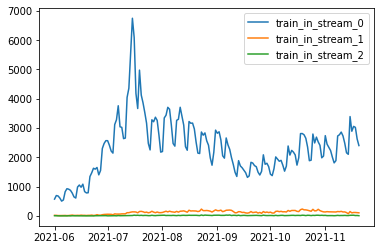

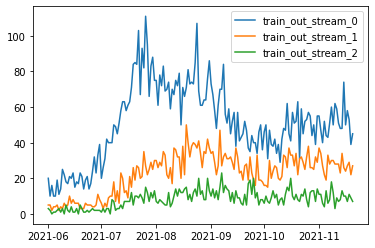

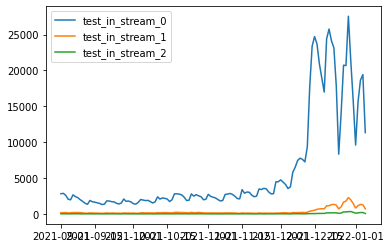

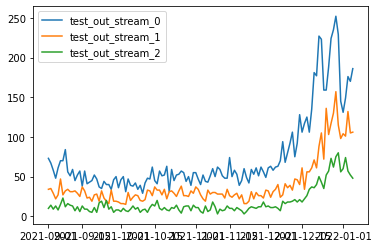

In [10]:
plt.clf()
for i in range(0,3):
    plt.plot(dates_train, train_in_stream[i], label="train_in_stream_%d" % i)
plt.legend()
plt.show()
plt.clf()
for i in range(0,3):
    plt.plot(dates_train, train_out_stream[i], label="train_out_stream_%d" % i)
plt.legend()
plt.show()
plt.clf()
for i in range(0,3):
    plt.plot(dates_test, test_in_stream[i], label="test_in_stream_%d" % i)
plt.legend()
plt.show()
plt.clf()
for i in range(0,3):
    plt.plot(dates_test, test_out_stream[i], label="test_out_stream_%d" % i)
plt.legend()
plt.show()


In [11]:
n_dim = 45
n_particles = 2000

x_maxes = [0.01, 0.04,0.1]
x_mins = [-0.003,-0.004,-0.01]
options = {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
init_pos = 0*np.array([np.ones(n_dim) for i in range(n_particles)])

minimizers = [[],[],[]]

for i in range(0,3):
    print(i)
    PSO_in_stream = train_in_stream[i] # globals!
    PSO_out_stream = train_out_stream[i]
    x_max = x_maxes[i]*np.ones(n_dim)
    x_min = x_mins[i]*np.ones(n_dim)
    bounds = (x_min, x_max)
    _minimizers = []
    
    def _f(x, in_stream, out_stream):
        # model out_stream as a convolution of in_stream with x
        target_out_stream = out_stream[len(x)-1:]
        pred_out_stream = np.convolve(in_stream, x, mode="valid")
        return target_out_stream, pred_out_stream

    def f(xs, in_stream=PSO_in_stream, out_stream=PSO_out_stream):
        ret = np.zeros(np.shape(xs)[0])
        for j in range(len(ret)):
            x = xs[j,:]
            target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
            ret[j] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
        return ret      
    
    for j in range(15):
        optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
        cost, pos = optimizer.optimize(f, 500, verbose=True, n_processes=10)
        _minimizers.append(pos)
    minimizers[i] = _minimizers

2022-01-07 18:17:26,819 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}


0


pyswarms.single.global_best: 100%|██████████|500/500, best_cost=6.5 
2022-01-07 18:17:34,409 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.502545761011796, best pos: [ 4.85754094e-04 -1.64531598e-04  1.26170540e-03  2.24823061e-04
  5.92629518e-04  1.03467734e-03  2.33046135e-03  1.98947524e-03
  2.44689997e-03  4.72769037e-04  5.86673330e-04  2.65609839e-03
  6.19259262e-04  5.01495814e-04  1.35447130e-03  8.45155317e-04
  1.91180961e-03 -1.98674245e-04 -1.27056760e-03  9.36389127e-04
  9.20251457e-04  1.69091161e-03 -8.32375794e-04  1.46605047e-03
  3.68627724e-04 -5.47460997e-04 -3.81311127e-04  4.88092261e-04
  1.11871698e-03 -4.00459815e-05 -2.99981069e-03 -2.75588339e-03
  1.45851958e-03  1.05186618e-03  9.62513021e-04  3.75636965e-04
 -2.22806092e-04  1.21806713e-03  2.20292520e-04 -1.29541114e-05
  4.03949675e-04 -3.02503839e-04  1.01555854e-03 -4.42717133e-04
  4.97490710e-04]
2022-01-07 18:17:34,427 - pyswarms.single.global_best - INFO - Optimize

2022-01-07 18:18:24,410 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=6.41
2022-01-07 18:18:31,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.412917454502847, best pos: [ 2.30828241e-03 -4.85429441e-04  2.07138695e-04 -7.46256870e-05
 -4.96830437e-04  2.11901525e-03  5.67639148e-03  2.64430489e-04
 -5.66794044e-04  3.19895340e-04  1.16618079e-03  3.54416246e-03
  2.81233246e-03 -2.18929951e-04  1.70952918e-03 -9.14841789e-06
 -4.26120239e-04  2.14412067e-03 -5.08520923e-04 -4.49063548e-04
 -4.52033154e-04  1.71107712e-03  8.43468963e-04 -4.02259189e-04
  6.00066374e-04 -4.00649589e-05 -9.68983680e-04  4.32543929e-04
  7.36675557e-04 -4.36135910e-04  9.30599613e-04 -5.95936506e-04
 -9.04680280e-04 -1.32416671e-03 -1.09178335e-03  1.66361864e-03
  9.48734474e-04  2.08580362e-03 -1.35410197e-03 -4.10618630e-05
  8.91162172e-04  1.96379523e-

1


pyswarms.single.global_best: 100%|██████████|500/500, best_cost=4.65
2022-01-07 18:19:14,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.651633342388511, best pos: [ 0.00395335  0.0112824   0.02032522  0.00798219  0.00751545  0.01184507
  0.00659429  0.03980614  0.00827629  0.01511261  0.0022969   0.0164179
  0.0013432   0.01373726  0.00887908  0.01207253 -0.00399279  0.00370677
  0.00262436 -0.00258921  0.00104549  0.00024898 -0.00384963  0.00992783
  0.00926099 -0.00394176 -0.00387594  0.00268953  0.00563211  0.00050056
  0.00051809 -0.00137322 -0.00398771 -0.00231406  0.00275207  0.00709103
 -0.00379702 -0.00356053 -0.00347114 -0.00338843 -0.00275914 -0.00363048
  0.00222414 -0.0039407  -0.00394352]
2022-01-07 18:19:14,051 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=4.66
2022-01-07 18:19:19,288 - pyswarms.single.global_best - INFO - 

2022-01-07 18:19:56,378 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=4.58
2022-01-07 18:20:01,610 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.584928096715502, best pos: [ 0.03509782  0.02081343  0.00546632  0.00777982  0.01318296  0.0038221
  0.01339698  0.02541272  0.007092    0.02759975 -0.00078348  0.00327945
  0.00690873 -0.00389612  0.0064236   0.01411498  0.00402583  0.00439634
  0.00030486  0.01007218  0.00793536 -0.00118783 -0.00345987  0.00059308
 -0.00161235 -0.0039542  -0.00047658 -0.00207472  0.00562245  0.00137935
 -0.00128662 -0.00067132 -0.00399819  0.00171616 -0.00168432  0.00567146
 -0.00280592 -0.00242768 -0.00367749 -0.00397091 -0.0037572  -0.0037611
  0.00215577 -0.00394809 -0.00398351]
2022-01-07 18:20:01,631 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.

2


pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.74
2022-01-07 18:20:33,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.743236776146843, best pos: [ 0.07881108  0.07088024  0.04341035  0.03038694  0.05777337  0.02464727
  0.01627723  0.00897098  0.02188987  0.00557484  0.00652104  0.01583667
  0.02754159  0.00552812  0.02928876  0.05993724  0.02159995  0.01364569
 -0.00995742  0.00795746  0.00188619  0.02604648 -0.00979082 -0.00427688
 -0.00969167 -0.00878767  0.04256471  0.00727721  0.00206195 -0.00990759
  0.02739749 -0.00477589 -0.00738664 -0.00595648 -0.00915297  0.00020792
  0.01741438 -0.00971466  0.01528523  0.01767311  0.00817214  0.01466749
 -0.00717605 -0.00975909 -0.00969945]
2022-01-07 18:20:33,357 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.74
2022-01-07 18:20:38,514 - pyswarms.single.global_best - INFO -

2022-01-07 18:21:20,916 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=2.69
2022-01-07 18:21:26,307 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.6924146752667046, best pos: [ 0.09158973  0.03935128  0.04032346  0.01636478  0.09122291  0.04587052
  0.04467303  0.00341464  0.02017044  0.01220822  0.03469065  0.01738179
  0.00485279  0.01278221  0.00866122  0.04105171  0.01948882  0.02965805
 -0.00975841 -0.00781271 -0.00967312 -0.0082287  -0.00960249  0.0086668
 -0.00955528 -0.0006148   0.01069352  0.00727425  0.00825581 -0.00969273
  0.010256    0.01615914  0.00498837  0.00356453 -0.00988759 -0.00075713
  0.02005353 -0.00960286  0.01148231  0.02560639 -0.00952645 -0.00932965
  0.01017023  0.01015352 -0.00963504]
2022-01-07 18:21:26,317 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.4, 'w': 0.5}
pyswarm

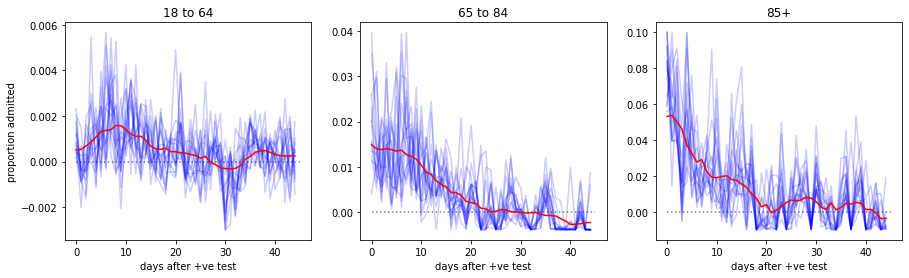

<Figure size 432x288 with 0 Axes>

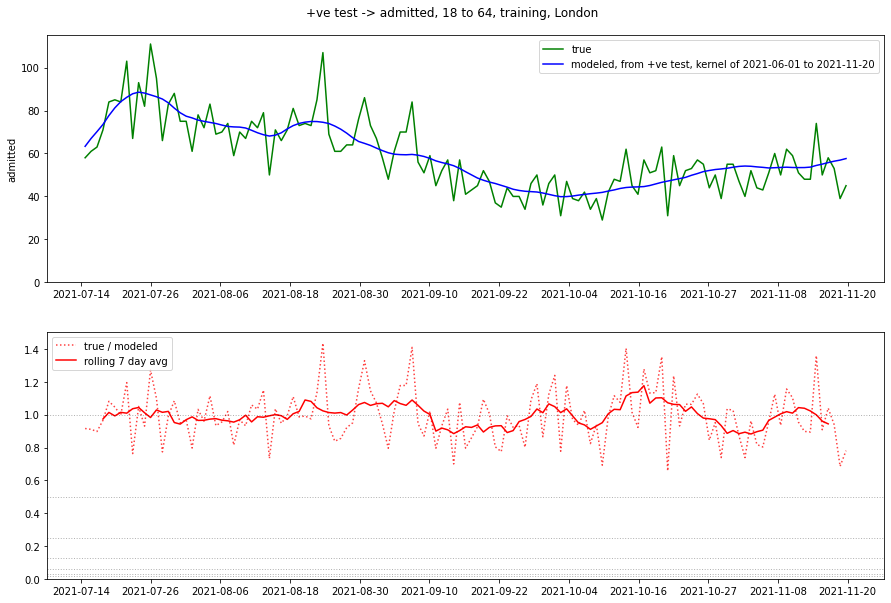

<Figure size 432x288 with 0 Axes>

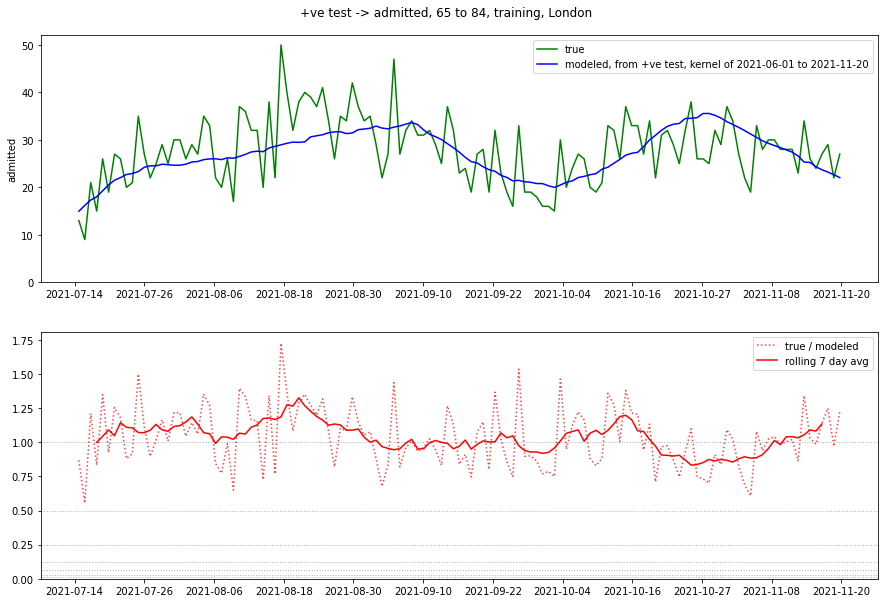

<Figure size 432x288 with 0 Axes>

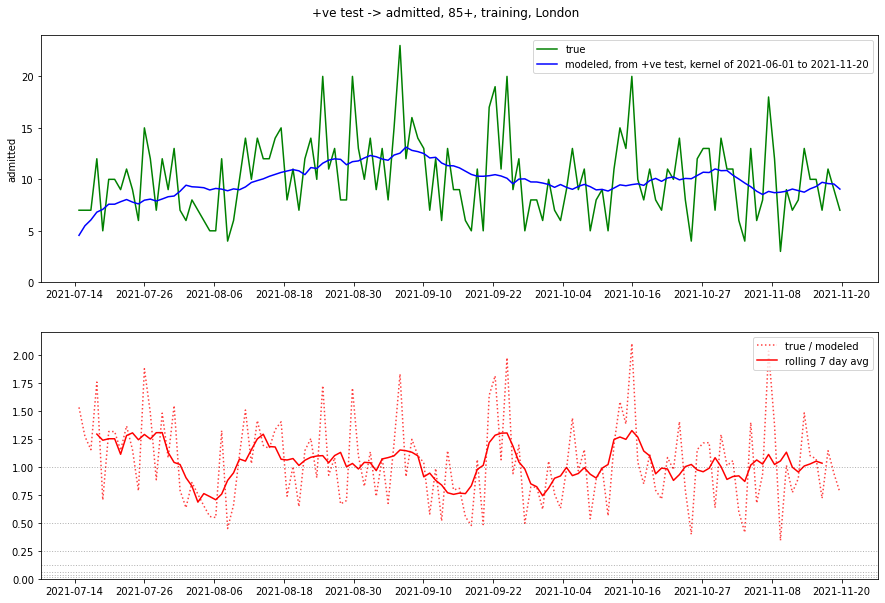

0.48185834813965633


<Figure size 432x288 with 0 Axes>

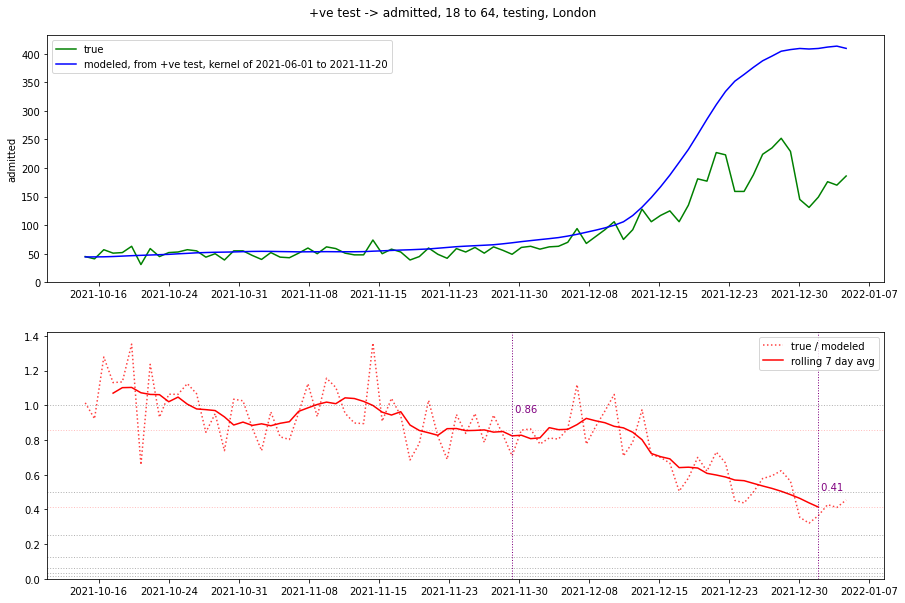

0.3147757668872109


<Figure size 432x288 with 0 Axes>

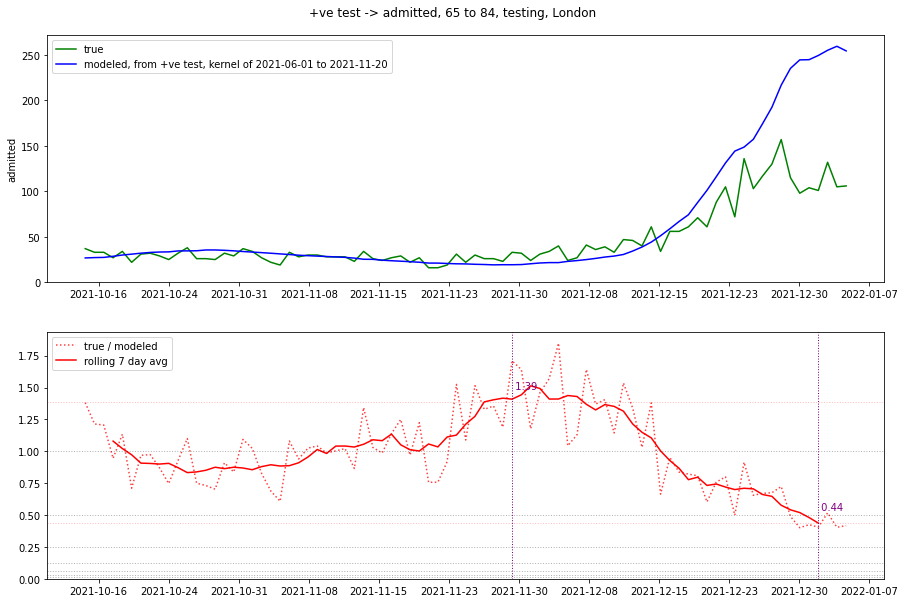

0.462953414749282


<Figure size 432x288 with 0 Axes>

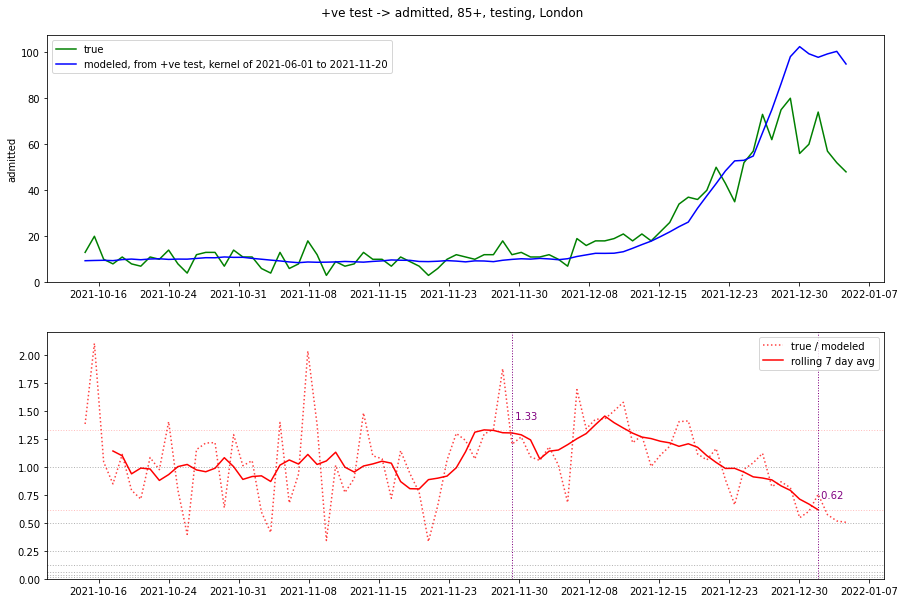

In [12]:
# show kernels
minimizers = np.array(minimizers) # todo: fix some deprecation err
avg_minimizer = [[],[],[]]
fig, axes = plt.subplots(1,3, figsize=(15,4))
z = list(range(len(pos)))
for i in range(0,3):
    ax = axes[i]
    for y in minimizers[i]:
        ax.plot(z, y, color="blue", alpha=0.2)
    avg_minimizer[i] = []
    for j in range(len(minimizers[i][0])):
        avg_minimizer[i].append(np.mean(minimizers[i,:,j]))
    avg_minimizer[i] = np.array(avg_minimizer[i])
    avg_minimizer[i] = N_avg_soft(avg_minimizer[i], 3) 
    ax.plot(z, avg_minimizer[i], color="red", alpha=1)
    ax.set_xlabel("days after %s" % in_event)
    if i==0:
        ax.set_ylabel("proportion %s" % out_event)
    ax.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
    ax.set_title(band_label[i])
    plt.savefig("%s__%s__kernel__%s__age_stratified.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train, band_label, allow_scaling=False):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(kernel, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    test_scale_factor = 1
    final_scale_factor = None
    if test_train=="test":
        if allow_scaling:
            test_scale_factor = avg_diff[np.isfinite(avg_diff)][0]
        pred *= test_scale_factor
        diff /= test_scale_factor
        avg_diff = N_avg_hard(diff, 3)
        final_scale_factor = avg_diff[np.isfinite(avg_diff)][-1]
        comp_idx = dates.index(datetime.datetime(year=2021,month=12,day=1))
        comp_idx = len(dates) - comp_idx + 1
        comp_scale = avg_diff[np.isfinite(avg_diff)][-comp_idx]
    
    ax1.plot(x, true, color="green", label="true")
    modeled_label = "modeled, from %s, kernel of %s to %s" % (in_event, train_start_date.strftime("%Y-%m-%d"), train_end_date.strftime("%Y-%m-%d"))
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.set_ylim(0,None)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff, color="red", alpha=0.75, ls="dotted", label="true / modeled") # unscaled
    ax2.plot(x, avg_diff, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        if allow_scaling:
            ax2.axvline(x=x[3], color="black", ls="dotted")
            ax1.axvline(x=x[3], color="black", ls="dotted")
            y_min,y_max = ax1.get_ylim()
            y_mid = (y_min+y_max)/2 
            ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), test_scale_factor), ha="left")
        ax2.axhline(y=final_scale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], final_scale_factor+0.1, " %.2f" % (final_scale_factor), ha="left", color="purple")    
        ax2.axvline(x=x[-4], color="purple", ls="dotted", lw=1)
        ax2.axhline(y=comp_scale, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-comp_idx], comp_scale+0.1, " %.2f" % (comp_scale), ha="left", color="purple")    
        ax2.axvline(x=x[-comp_idx], color="purple", ls="dotted", lw=1)
        print(final_scale_factor/comp_scale)
    
    fig.suptitle("%s -> %s, %s, %sing, %s" % (in_event, out_event, band_label, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s__%s.png" % (in_event, out_event, band_label, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    return test_scale_factor, final_scale_factor
    
for i in range(3):
    make_graph(dates_train, avg_minimizer[i], train_in_stream[i], train_out_stream[i], "train", band_label[i]) 
for i in range(3):
    make_graph(dates_test, avg_minimizer[i], test_in_stream[i], test_out_stream[i], "test", band_label[i]) 




0.000516,0.000534,0.000684,0.000863,0.001079,0.001326,0.001370,0.001406,0.001581,0.001574,0.001404,0.001208,0.001107,0.001112,0.000938,0.000678,0.000558,0.000535,0.000586,0.000439,0.000430,0.000386,0.000374,0.000316,0.000264,0.000152,0.000222,-0.000033,-0.000129,-0.000272,-0.000305,-0.000325,-0.000299,-0.000185,0.000100,0.000226,0.000411,0.000461,0.000486,0.000408,0.000315,0.000259,0.000242,0.000248,0.000245

0.014860,0.013990,0.013809,0.014020,0.013792,0.013463,0.013683,0.012708,0.012286,0.011675,0.010363,0.008821,0.008251,0.006902,0.006048,0.005537,0.004309,0.004257,0.003636,0.002354,0.002065,0.001838,0.000816,0.000643,-0.000017,0.000131,0.000492,0.000432,0.000042,-0.000040,-0.000136,-0.000273,-0.000186,-0.000151,-0.000521,-0.000788,-0.000797,-0.000905,-0.001477,-0.002018,-0.002778,-0.002736,-0.002637,-0.002401,-0.002347

0.053116,0.053664,0.050200,0.046200,0.037195,0.032604,0.027774,0.029192,0.022481,0.019265,0.019050,0.019709,0.020120,0.018063,0.017579,0.015459,0.013672,0.010142,0.

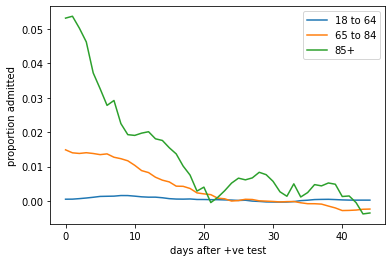

In [13]:
def format_minimizer(a):
    s = ",".join(["%.6f"%x for x in a])
    print(s)
    
format_minimizer(avg_minimizer[0])
print("")
format_minimizer(avg_minimizer[1])
print("")
format_minimizer(avg_minimizer[2])

plt.clf()
for i in range(3):
    z = range(len(avg_minimizer[0]))
    plt.plot(z, avg_minimizer[i], label="%s"%band_label[i])
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.legend()
plt.show()
